In [121]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import pandas as pd

In [14]:
np.sqrt(np.sum(np.power(np.array([0,0,0]) - np.array([1,1,1]),2.0)))

1.7320508075688772

In [2]:
stims = np.array([[0,0,0],
         [0,0,1],
         [0,1,0],
         [0,1,1],
         [1,0,0],
         [1,0,1],
         [1,1,0],
         [1,1,1]], dtype=np.float32)

labels = np.array([
                    [0,0,0,0,1,1,1,1], # type 1
                    [0,0,1,1,1,1,0,0], # type 2
                    [1,1,1,0,0,1,0,0], # type 3
                    [1,1,1,0,1,0,0,0], # type 4
                    [1,1,1,0,0,0,0,1], # type 5
                    [1,0,0,1,0,1,1,0]  # type 6
                ], dtype=np.float32)


In [172]:
runs_df = []
for problem in range(labels.shape[0]):
    for i in range(100):
        model = keras.Sequential([
            layers.Dense(5, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.005), loss="binary_crossentropy", metrics=["accuracy"])
        history = model.fit(stims, labels[problem], epochs=100, batch_size=8, verbose=False)
        run_df=pd.DataFrame(history.history)
        run_df['error']=1.0-run_df['accuracy']
        run_df['block']=run_df.index
        run_df['run']=i
        run_df['problem']=problem+1
        runs_df.append(run_df)
runs_df = pd.concat(runs_df)


In [108]:
runs_df.head()

,loss,accuracy,error,block,run,problem
0,0.663492,0.750,0.250,0,0,0
1,0.658746,0.625,0.375,1,0,0
2,0.655073,0.625,0.375,2,0,0
3,0.652146,0.625,0.375,3,0,0
4,0.649537,0.625,0.375,4,0,0


<AxesSubplot:xlabel='block', ylabel='error'>

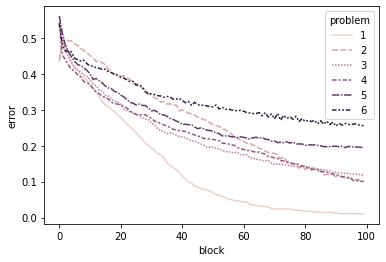

In [133]:
sns.lineplot(x='block',y='error',style='problem',hue='problem',data=runs_df.groupby(["block","problem"]).mean())

## Alcove Implementation

2. custom loss to use humble teacher
(2b. it should 1 sigmoid 2 softmax)

In [83]:
class ALCOVE(keras.Model):
    def __init__(self, exemplars, c=6.5, phi=2.5):
        super().__init__()
        self.exemplars = tf.dtypes.cast(exemplars, tf.float32)
        self.ne = exemplars.shape[0]
        self.attn = tf.Variable(np.ones((3,))/3.0, dtype=tf.float32, trainable=True)
        self.output_layer = layers.Dense(1, activation="sigmoid", use_bias=False)  # later this should be two output and humble teacher loss
        self.c = c
        self.phi = phi

    def get_attention(self):
        return self.attn.numpy()

    def call(self, inputs):
        h_acts = []
        for n_ins in range(inputs.shape[0]):
            h_act = tf.math.exp(-self.c*tf.reduce_sum(self.attn*tf.math.abs(self.exemplars - inputs[n_ins]),1))
            h_acts.append(h_act)
        output = self.output_layer(tf.stack(h_acts))
        return output

# This doesn't work, saving custom objects is harder than this apparently
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath='./model_checkpoints/model-{epoch:02d}.hd5',
#     save_weights_only=False,
#     save_best_only=False,
#     save_freq="epoch"
# )

print_attn = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: print(model.get_attention()))



In [72]:
model.attn

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0.41820854, 0.2939604 , 0.14120565], dtype=float32)>

In [84]:
problem = 1
model = ALCOVE(stims)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.005), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(stims, labels[problem], epochs=100, batch_size=8, verbose=True, callbacks=[print_attn])
run_df=pd.DataFrame(history.history)
run_df['error']=1.0-run_df['accuracy']
run_df['block']=run_df.index
run_df['problem']=problem+1


Epoch 1/100
1/1 [==============================] - 0s 409ms/step - loss: 0.7611 - accuracy: 0.2500
[0.31752205 0.31752208 0.3491446 ]
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7520 - accuracy: 0.3750
[0.30643716 0.3065025  0.35908228]
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7460 - accuracy: 0.3750
[0.2974273  0.29759213 0.36667418]
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.7412 - accuracy: 0.3750
[0.28966844 0.28996146 0.37292734]
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.7372 - accuracy: 0.3750
[0.2827874 0.283237  0.3782854]
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.7337 - accuracy: 0.3750
[0.27658406 0.2772205  0.3829869 ]
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7306 - accuracy: 0.3750
[0.27094153 0.27179825 0.38717568]
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7278

In [49]:
model=ALCOVE(stims)
model(stims[6:7])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.40135992]], dtype=float32)>

In [53]:
model.attn

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0.80867213, 0.79613686, 0.77792245], dtype=float32)>

In [63]:
runs_df = []
for problem in range(labels.shape[0]):
    for i in range(2):
        model = ALCOVE(stims)
        model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.005), loss="binary_crossentropy", metrics=["accuracy"])
        history = model.fit(stims, labels[problem], epochs=100, batch_size=8, verbose=False)
        run_df=pd.DataFrame(history.history)
        run_df['error']=1.0-run_df['accuracy']
        run_df['block']=run_df.index
        run_df['run']=i
        run_df['problem']=problem+1
        runs_df.append(run_df)
runs_df = pd.concat(runs_df)

<AxesSubplot:xlabel='block', ylabel='error'>

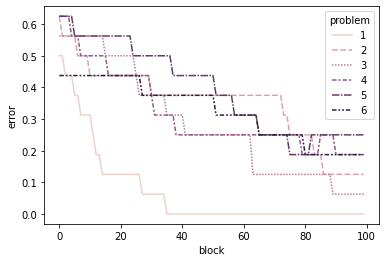

In [52]:
sns.lineplot(x='block',y='error',style='problem',hue='problem',data=runs_df.groupby(["block","problem"]).mean())

## Try 2: Custom Exemplar Layer in the sequential model

In [149]:
class ALCOVE_RBF(keras.layers.Layer):

    def __init__(self, exemplars, c=6.5, **kwargs):
        super().__init__(**kwargs)
        self.exemplars = tf.dtypes.cast(exemplars, tf.float32)
        self.ne = exemplars.shape[0]
        self.ndims = exemplars.shape[1]
        self.c = c

    def get_attention(self):
        return self.attn.numpy()
    
    def build(self, input_shape):
        self.ndims = input_shape[-1]
        self.attn = tf.Variable(np.ones((self.ndims ,))/float(self.ndims), dtype=tf.float32, trainable=True)

    def call(self, inputs):
        h_acts = []
        print(inputs)
        for n_ins in range(inputs.shape[0]):
            h_act = tf.math.exp(-self.c*tf.reduce_sum(self.attn*tf.math.abs(self.exemplars - inputs[n_ins]),1))
            h_acts.append(h_act)
        output = tf.stack(h_acts)
        return output


In [133]:
model = keras.Sequential(name="ALCOVE")
model.add(ALCOVE_RBF(stims, name="exemplar_layer"))
model.add(layers.Dense(1, activation="sigmoid", name="output_layer"))

yes this model makes sensible predictions still

In [116]:
model(stims[0:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.37439054]], dtype=float32)>

let's apply it to the type 2 problem:

In [156]:
model = keras.Sequential(name="ALCOVE")
model.add(keras.Input(shape=(3,)))  ## this doesn't work
model.add(ALCOVE_RBF(stims, name="exemplar_layer"))
model.add(layers.Dense(1, activation="sigmoid", name="output_layer"))

Tensor("Placeholder:0", shape=(None, 3), dtype=float32)


TypeError: in user code:

    <ipython-input-149-2b873d6d53b7>:20 call  *
        for n_ins in range(inputs.shape[0]):
    /Users/gureckis/.virtualenvs/science/lib/python3.9/site-packages/tensorflow/python/autograph/operators/py_builtins.py:365 range_  **
        return _py_range(start_or_stop, stop, step)
    /Users/gureckis/.virtualenvs/science/lib/python3.9/site-packages/tensorflow/python/autograph/operators/py_builtins.py:390 _py_range
        return range(start_or_stop)

    TypeError: 'NoneType' object cannot be interpreted as an integer


Tensor("Placeholder:0", shape=(1, 3), dtype=float32)
tf.Tensor([[0. 0. 0.]], shape=(1, 3), dtype=float32)
Epoch 1/100
Tensor("Placeholder:0", shape=(None, 3), dtype=float32)
Tensor("IteratorGetNext:0", shape=(8, 3), dtype=float32)
Tensor("IteratorGetNext:0", shape=(8, 3), dtype=float32)
1/1 [==============================] - 0s 431ms/step - loss: 0.8177 - accuracy: 0.2500
[0.23846541 0.23846543 0.42820096]
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7590 - accuracy: 0.5000
[0.17708868 0.17814264 0.42872465]
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7334 - accuracy: 0.5000
[0.1418153  0.14552788 0.40953648]
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7202 - accuracy: 0.5000
[0.13048422 0.13730028 0.3802827 ]
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 0.7117 - accuracy: 0.5000
[0.13385274 0.14185229 0.3420415 ]
Epoch 6/100
1/1 [==============================] - 0s 2ms/step

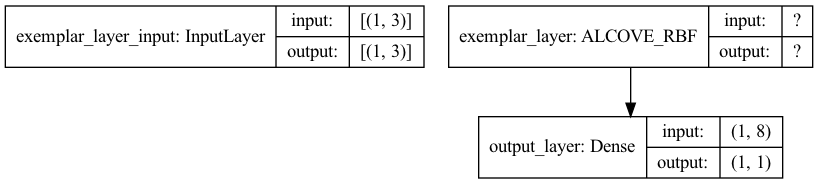

In [157]:
problem = 1
# model = keras.Sequential([
#     ALCOVE_RBF(stims),
#     layers.Dense(1, activation="sigmoid")
# ])
model = keras.Sequential(name="ALCOVE")
#model.add(keras.Input(shape=(3,)))  ## this doesn't work but needs to for the multi optimizer to wrok
model.add(ALCOVE_RBF(stims, name="exemplar_layer"))
model.add(layers.Dense(1, activation="sigmoid", name="output_layer"))
model(stims[0:1])  # <-- needed because I can't figure out the symbolic shape 

# this is a custom call back whcih prints the value of the attention weights
print_attn = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_attention()))

optimizers = [
    tf.keras.optimizers.RMSprop(learning_rate=0.0033),  # different learning rate for first later
    tf.keras.optimizers.RMSprop(learning_rate=0.03) # than for the rest
]
optimizers_and_layers = [(optimizers[1], model.layers[0]), (optimizers[1], model.layers[1])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

# change the loss!!
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(stims, labels[problem], epochs=100, batch_size=8, verbose=True, callbacks=[print_attn])
run_df=pd.DataFrame(history.history)
run_df['error']=1.0-run_df['accuracy']
run_df['block']=run_df.index
run_df['problem']=problem+1

keras.utils.plot_model(model, show_shapes=True)

In [129]:
model.layers